In [1]:
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-11-20 23:06:47.936845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        self.u = self.add_weight(
            name="att_u",
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # u_it = tanh(h_t W + b)
        u_it = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        # score = u_it · u
        score = tf.tensordot(u_it, self.u, axes=1)  # (batch_size, timesteps)
        # attention weights
        alphas = tf.nn.softmax(score, axis=1)       # (batch_size, timesteps)
        # context vector = sum_t alpha_t * h_t
        context = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return context

    def compute_output_shape(self, input_shape):
        # Returns (batch_size, features)
        return (input_shape[0], input_shape[-1])


In [3]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (9840, 3)
Test Shape: (2109, 3)


In [4]:
def handle_emojis(text):
    return emoji.demojize(str(text), delimiters=(" ", " "))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-zA-Z0-9\u0900-\u097F\s:]", "", text)
    return text.strip()

def preprocess_text(text):
    text = handle_emojis(text)
    text = clean_text(text)
    return text

train_df["Tweet"] = train_df["Tweet"].apply(preprocess_text)
test_df["Tweet"]  = test_df["Tweet"].apply(preprocess_text)

In [5]:
label_encoder = LabelEncoder()
train_df["Label"] = label_encoder.fit_transform(train_df["Label"])
test_df["Label"]  = label_encoder.transform(test_df["Label"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'NO': np.int64(0), 'YES': np.int64(1)}


In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["Tweet"], train_df["Label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["Label"]
)

In [7]:
# Tokenization & Padding

MAX_NUM_WORDS = 50000
MAX_SEQ_LEN   = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=MAX_SEQ_LEN, padding="post")
X_val   = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=MAX_SEQ_LEN, padding="post")
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_df["Tweet"]), maxlen=MAX_SEQ_LEN, padding="post")

y_train, y_val, y_test = train_labels.values, val_labels.values, test_df["Label"].values

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (7872, 50) (7872,)
Val: (1968, 50) (1968,)
Test: (2109, 50) (2109,)


In [8]:
embedding_path = "assets/cc.hi.300.vec"
embeddings_index = {}
with open(embedding_path, encoding="utf-8", errors="ignore") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
print("Total Embeddings Loaded:", len(embeddings_index))

word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
print("Embedding Matrix Shape:", embedding_matrix.shape)

Total Embeddings Loaded: 1876654
Embedding Matrix Shape: (22012, 300)


In [9]:
# Model

model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

model.summary()

# Training

early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_bilstm.h5", monitor="val_accuracy",
                             save_best_only=True, mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

/home/kunj/dau/semester_7/it594_deep_neural_nlp_and_applications/project/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1763660274.421159  125083 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-11-20 23:07:55.254432: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26414400 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,603,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,603,600 (25.19 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,603,600 (25.19 MB)

Epoch 1/20


2025-11-20 23:07:58.737624: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8703 - loss: 0.3326

2025-11-20 23:08:18.827154: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26414400 exceeds 10% of free system memory.
2025-11-20 23:08:19.240332: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26414400 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from None to 0.93445, saving model to best_bilstm.h5


2025-11-20 23:08:20.108375: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26414400 exceeds 10% of free system memory.


123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 171ms/step - accuracy: 0.9098 - loss: 0.2490 - val_accuracy: 0.9345 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 2/20
120/123 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9396 - loss: 0.1678
Epoch 2: val_accuracy did not improve from 0.93445
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9409 - loss: 0.1646 - val_accuracy: 0.9339 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 3/20
  9/123 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9639 - loss: 0.1124

2025-11-20 23:08:24.474451: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26414400 exceeds 10% of free system memory.


121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9540 - loss: 0.1338
Epoch 3: val_accuracy improved from 0.93445 to 0.93598, saving model to best_bilstm.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9520 - loss: 0.1375 - val_accuracy: 0.9360 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 4/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9667 - loss: 0.1013
Epoch 4: val_accuracy did not improve from 0.93598

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9611 - loss: 0.1109 - val_accuracy: 0.8897 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9729 - loss: 0.0839
Epoch 5: val_accuracy did not improve from 0.93598
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9728 - loss: 0.0812 - val_accuracy: 0.9253 - val_loss: 0.2170 - learning_rate: 5.0000e-04
Epoch 6/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9775 - loss: 0.0752
Epoch 6: val_accuracy did not improve from 0.93598

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1

Validation Accuracy: 0.9360, Validation Loss: 0.1674
Test Accuracy: 0.9341, Test Loss: 0.1579
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation Classification Report:
              precision    recall  f1-score   support

          NO       0.89      0.93      0.91       669
         YES       0.96      0.94      0.95      1299

    accuracy                           0.94      1968
   macro avg       0.93      0.93      0.93      1968
weighted avg       0.94      0.94      0.94      1968

Test Classification Report:
              precision    recall  f1-score   support

          NO       0.88      0.92      0.90       706
         YES       0.96      0.94      0.95      1403

    accuracy                           0.93      2109
   macro avg       0.92      0.93      0.93      2109
weighted avg       0.94      0.93      0.93      2109



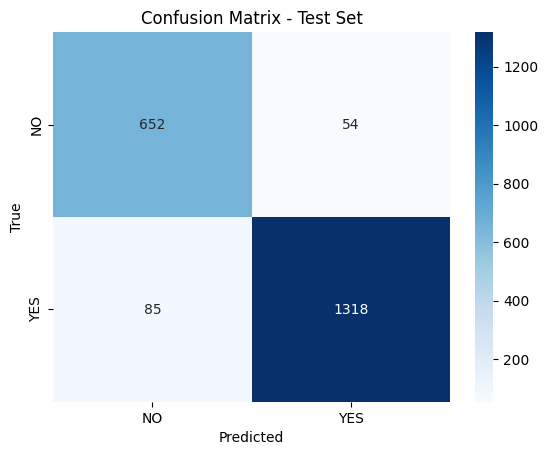

In [10]:
# Evaluation

best_model = load_model("best_bilstm.h5")
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Reports

y_pred_val = (best_model.predict(X_val) > 0.5).astype(int).flatten()
y_pred_test = (best_model.predict(X_test) > 0.5).astype(int).flatten()

print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()



In [11]:
# Option: make embeddings fine-tunable
EMBED_TRAINABLE = True  # change to False if overfitting

inputs = Input(shape=(MAX_SEQ_LEN,), name="input_ids")

x = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LEN,
    trainable=EMBED_TRAINABLE,
    name="embedding"
)(inputs)

# BiLSTM that returns full sequence
x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm_1")(x)
x = Dropout(0.4, name="dropout_1")(x)

# Attention over time dimension
x = Attention(name="attention")(x)

# Optional second (small) dense layer
x = Dense(128, activation="relu", name="dense_1")(x)
x = Dropout(0.3, name="dropout_2")(x)

outputs = Dense(1, activation="sigmoid", name="output")(x)

attn_model = Model(inputs=inputs, outputs=outputs, name="BiLSTM_Attention")

attn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

attn_model.summary()


/home/kunj/dau/semester_7/it594_deep_neural_nlp_and_applications/project/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │     6,603,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 50, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,141,969 (27.24 MB)

 Trainable params: 7,141,969 (27.24 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
checkpoint_attn = ModelCheckpoint("best_bilstm_attn.h5", monitor="val_accuracy",
                                  save_best_only=True, mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history_attn = attn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, checkpoint_attn, reduce_lr],
    verbose=1
)


Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8628 - loss: 0.2896
Epoch 1: val_accuracy improved from None to 0.96697, saving model to best_bilstm_attn.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.9277 - loss: 0.1843 - val_accuracy: 0.9670 - val_loss: 0.0838 - learning_rate: 0.0010
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9822 - loss: 0.0492
Epoch 2: val_accuracy improved from 0.96697 to 0.97104, saving model to best_bilstm_attn.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9826 - loss: 0.0462 - val_accuracy: 0.9710 - val_loss: 0.0843 - learning_rate: 0.0010
Epoch 3/20
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9959 - loss: 0.0108
Epoch 3: val_accuracy did not improve from 0.97104

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9649 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 4/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9977 - loss: 0.0073
Epoch 4: val_accuracy improved from 0.97104 to 0.97154, saving model to best_bilstm_attn.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9715 - val_loss: 0.0925 - learning_rate: 5.0000e-04
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9997 - loss: 0.0030
Epoch 5: val_accuracy improved from 0.97154 to 0.97409, saving model to best_bilstm_attn.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9741 - val_loss: 0.1125 - learning_rate: 5.0000e-04


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
== BiLSTM + Attention ==
Validation Accuracy: 0.9741, Validation Loss: 0.1125
Test Accuracy: 0.9711, Test Loss: 0.1054

Validation Classification Report:
              precision    recall  f1-score   support

          NO       0.98      0.95      0.96       669
         YES       0.97      0.99      0.98      1299

    accuracy                           0.97      1968
   macro avg       0.97      0.97      0.97      1968
weighted avg       0.97      0.97      0.97      1968


Test Classification Report:
              precision    recall  f1-score   support

          NO       0.97      0.94      0.96       706
         YES       0.97      0.98      0.98      1403

    accuracy                           0.97      2109
   macro avg       0.97      0.96      0.97      2109
weighted avg       0.97      0.97      0.97      2109



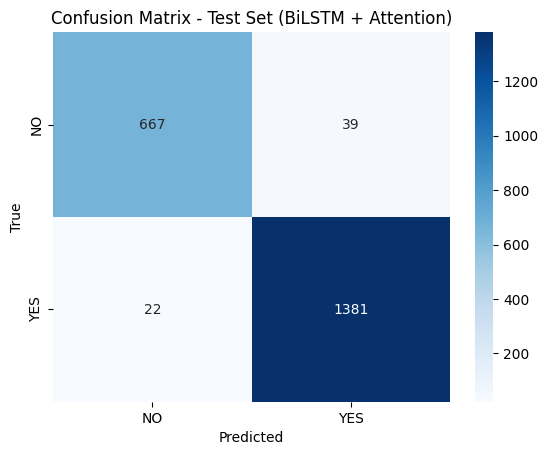

In [13]:
best_attn_model = load_model("best_bilstm_attn.h5", custom_objects={"Attention": Attention})

val_loss_attn, val_acc_attn = best_attn_model.evaluate(X_val, y_val, verbose=0)
test_loss_attn, test_acc_attn = best_attn_model.evaluate(X_test, y_test, verbose=0)

y_pred_val_attn = (best_attn_model.predict(X_val) > 0.5).astype(int).flatten()
y_pred_test_attn = (best_attn_model.predict(X_test) > 0.5).astype(int).flatten()

print("== BiLSTM + Attention ==")
print(f"Validation Accuracy: {val_acc_attn:.4f}, Validation Loss: {val_loss_attn:.4f}")
print(f"Test Accuracy: {test_acc_attn:.4f}, Test Loss: {test_loss_attn:.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred_val_attn,
                            target_names=label_encoder.classes_))

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test_attn,
                            target_names=label_encoder.classes_))

cm_attn = confusion_matrix(y_test, y_pred_test_attn)
sns.heatmap(cm_attn, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set (BiLSTM + Attention)")
plt.show()
